In [90]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from jupyterthemes import jtplot
import re
import unidecode

jtplot.style()

def millions(x, pos):
    return '%1.f M€' % (x*1e-6)

def custom_parser(s):
    if type(s) == str:
        return pd.datetime.strptime(s, '%d/%m/%Y')
    return pd.np.nan


## Analyse des avantages des étudiants

In [2]:
iter_csv = pd.read_csv('../../data/tmp/declaration_avantage_2017_07_27_04_00.csv', 
                       parse_dates=['avant_date_signature'], 
                       date_parser=custom_parser,
                       iterator=True,
                       chunksize=1000,
                       sep=';')

avantage_data = pd.concat([chunk[chunk['benef_categorie_code'] == '[ETU]'] for chunk in iter_csv])

In [6]:
avantage_data.head()

,entreprise_identifiant,denomination_sociale,ligne_identifiant,ligne_rectification,benef_categorie_code,categorie,benef_nom,benef_prenom,benef_qualite_code,qualite,...,benef_etablissement_codepostal,benef_etablissement_ville,benef_denomination_sociale,benef_objet_social,ligne_type,avant_date_signature,avant_montant_ttc,avant_nature,avant_convention_lie,semestre
5,WMQRNJKV,IPSEN PHARMA,NAYA-MBE-270724_A_425208,N,[ETU],Etudiant,GUEUDRY,PAULINE,NaN,NaN,...,75000,NON CONNUE,NaN,NaN,[A],2015-11-04,21,REPAS,NaN,S2
6,WMQRNJKV,IPSEN PHARMA,NAYA-MBE-270721_A_215606,N,[ETU],Etudiant,CHOWANIEC,YVONNE,NaN,NaN,...,75000,NON CONNUE,NaN,NaN,[A],2015-11-04,21,REPAS,NaN,S2
7,WMQRNJKV,IPSEN PHARMA,NAYA-MBE-263838_A_391574,N,[ETU],Etudiant,KRHILI,SAMAR,NaN,NaN,...,75000,NON CONNUE,NaN,NaN,[A],2015-09-16,19,REPAS,NaN,S2
13,WMQRNJKV,IPSEN PHARMA,NAYA-MBE-259617_A_221855,N,[ETU],Etudiant,VALLE,ALINE,NaN,NaN,...,75000,NON CONNUE,NaN,NaN,[A],2015-10-01,572,TRANSPORT,NaN,S2
14,WMQRNJKV,IPSEN PHARMA,NAYA-MBE-259611_A_610768,N,[ETU],Etudiant,ROUGEON,VERONICA,NaN,NaN,...,75000,NON CONNUE,NaN,NaN,[A],2015-10-01,150,HEBERGEMENT,NaN,S2


**Montant total des avantages données aux étudiants depuis mi 2013**

In [21]:
print("Total des avantages depuis mi 2013 :", millions(avantage_data.avant_montant_ttc.sum(), ""))
print("Nombre d'avantages :", avantage_data.avant_montant_ttc.shape[0])
print("Montant moyen d'un avantage :", avantage_data.avant_montant_ttc.mean())

Total des avantages depuis mi 2013 : 18 M€
Nombre d'avantages : 333062
Montant moyen d'un avantage : 52.8228678144


### Evolution annuelle du montant des avantages

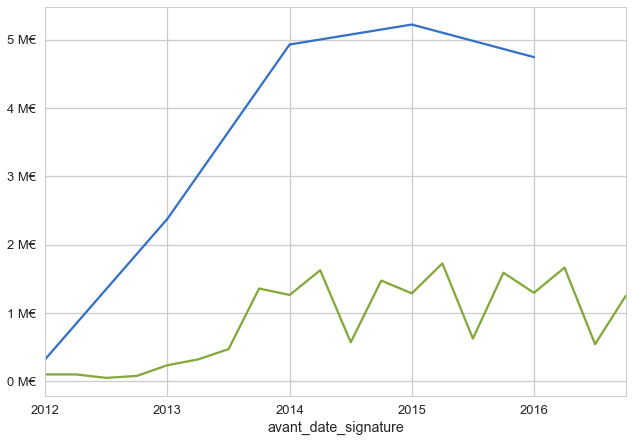

In [29]:
avantage_data_by_month = avantage_data.groupby(avantage_data.avant_date_signature.dt.to_period("M"))
avantage_data_by_quarter = avantage_data.groupby(avantage_data.avant_date_signature.dt.to_period("Q"))
avantage_data_by_year = avantage_data.groupby(avantage_data.avant_date_signature.dt.to_period("A"))

with sns.axes_style("whitegrid"):
    sns.set_context("talk")
    plot = avantage_data_by_year.avant_montant_ttc.sum().plot()
    formatter = mpl.ticker.FuncFormatter(millions)
    plot.yaxis.set_major_formatter(formatter)
    plot = avantage_data_by_quarter.avant_montant_ttc.sum().plot()
    formatter = mpl.ticker.FuncFormatter(millions)
    plot.yaxis.set_major_formatter(formatter)

### Montant des avantages par type

In [149]:
repas_re = re.compile('(repas|restauration|restaurant|dejeuner|diner|collation|bouche|coktail|cocktail|traiteur|buffet|reception)')
transport_re = re.compile('(transport|deplacement|train)')
hebergement_re = re.compile('(hebergement|hospitalite|nuit|voyage|hotel|bergement)')
congre_re = re.compile("(inscription|congres|invitation|conferences)")
autre_re = re.compile("(autre|divers|cadeau)")
don_re = re.compile("don")

def normalize_nature(nature):
    nature = unidecode.unidecode(nature).lower()
    if repas_re.search(nature):
        return "REPAS"
    if hebergement_re.search(nature):
        return "HEBERGEMENT"
    if transport_re.search(nature):
        return "TRANSPORT"
    if congre_re.search(nature):
        return "CONGRES"
    if don_re.search(nature):
        return "DON"
    if autre_re.search(nature):
        return "AUTRE"
    
    return nature

avantage_data["normalized_avant_nature"] = avantage_data.avant_nature.apply(normalize_nature)
avant_by_nature = avantage_data.groupby('normalized_avant_nature').sum()

In [150]:
avant_by_nature.reset_index(level=0, inplace=True)
avant_by_nature.sort_values(by="avant_montant_ttc", ascending=False, inplace=True)

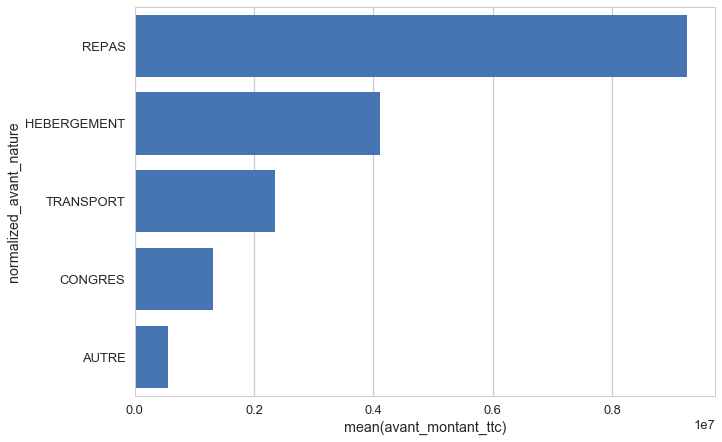

In [151]:
with sns.axes_style("whitegrid"):
    sns.set_context("talk")
    sns.barplot(x="avant_montant_ttc", y="normalized_avant_nature", data=avant_by_nature[:10], label="Total", color="b")